<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,1
1970-01-05,1
1970-01-06,1
1970-01-07,1
1970-01-08,1


In [6]:
states.state.value_counts()

6    2285
1    2125
3    2035
0    1667
4    1598
5    1350
2    1230
7    1031
Name: state, dtype: int64

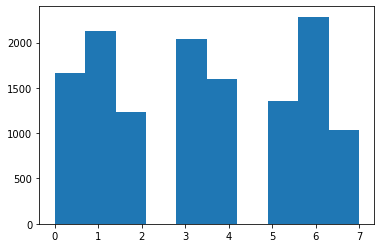

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 11, 3),
 datetime.date(2022, 10, 22),
 datetime.date(2012, 10, 24),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 11, 3), datetime.date(2022, 10, 22))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_38125/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_38125/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_38125/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_38125/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
A,1.000273,0.994637,1.000740,1.000461,1.001303,1.004183,1.002205,1.002147,1.018573
AA,1.000263,0.994059,1.000576,1.001251,1.001066,1.001915,1.000927,1.001338,1.001044
AAIC,0.999486,0.992098,1.000801,1.001835,1.000855,1.002348,1.001198,1.000292,1.013844
AAL,0.999934,0.993951,0.998774,1.002099,1.001523,1.011659,1.002196,1.001295,1.014194
AAME,0.999977,0.996085,0.999894,1.001152,1.001280,1.000642,1.000605,1.000221,1.001265


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
ZTEK,1.000544,0.996783,0.999030,0.996257,1.006215,1.005090,0.995486,1.001244,1.061323
ZTR,1.000184,0.998305,1.000084,1.000321,1.000758,1.000632,1.000473,1.000675,1.000882
ZUMZ,1.000118,0.994938,0.999056,1.001879,1.001180,1.009278,1.001557,1.001621,1.006405
ZWS,1.000076,0.992997,0.999816,1.000026,1.000446,1.006652,1.002426,1.001481,1.019849
ZYXI,1.000415,0.998549,1.002140,0.997746,0.998851,0.980432,0.996421,1.003007,1.047296


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

1

In [32]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]

df['weighted'] = {
    0: (0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar),
    1: (0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
ELC,1.001292,0.997516,1.008875,0.997929,1.000319,0.979371,1.003222,1.001085,0.984842,1.005128
GGE,1.000685,0.993298,1.006279,0.999944,1.001768,0.987707,1.004443,0.999882,0.977467,1.003229
LFMD,1.000394,0.997374,1.003798,1.001539,1.000115,0.983965,1.001882,0.999084,0.974470,1.002249
DTST,1.000527,1.010384,1.002153,0.996680,0.996152,0.945302,1.002060,1.000322,1.007483,1.002104
SOBR,1.000030,1.002576,1.003357,0.996042,1.002178,1.044877,0.999799,0.996427,1.052410,1.001882


In [33]:
df.mean(), df.median()

(dar         1.000157
 dar_0       0.996113
 dar_1       1.000062
 dar_2       1.000820
 dar_3       1.001160
 dar_4       1.002266
 dar_5       1.001292
 dar_6       1.000934
 dar_7       1.010238
 weighted    0.999760
 dtype: float64,
 dar         1.000251
 dar_0       0.996276
 dar_1       1.000241
 dar_2       1.000824
 dar_3       1.001173
 dar_4       1.001495
 dar_5       1.001212
 dar_6       1.000936
 dar_7       1.008658
 weighted    0.999975
 dtype: float64)

In [53]:
exclude = {
    0: [
        'ABST', 'AGI', 'AMEH', 'APT', 'BGS', 'CZFS', 'ELC', 'ESOA',
        'FNV', 'FSI', 'GCBC', 'GME', 'IDR', 'MTA', 'OLB', 'SVFD', 'WTRG'
    ],
    1: [
        'CVE', 'DTST', 'ELC', 'FSI', 'MOBQ']}

In [54]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [55]:
print(sorted(best_weighted))

['AMZN', 'CF', 'CSGP', 'CSIQ', 'CTSH', 'EPSN', 'FKWL', 'GCBC', 'GGE', 'LFMD', 'MICS', 'NTAP', 'PACB', 'PARR', 'SIX', 'SNEX', 'SOBR', 'UTHR', 'WKHS', 'ZYXI']


In [56]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
GGE,1.000685,0.993298,1.006279,0.999944,1.001768,0.987707,1.004443,0.999882,0.977467,1.003229
LFMD,1.000394,0.997374,1.003798,1.001539,1.000115,0.983965,1.001882,0.999084,0.974470,1.002249
SOBR,1.000030,1.002576,1.003357,0.996042,1.002178,1.044877,0.999799,0.996427,1.052410,1.001882
EPSN,1.000139,0.995457,1.002843,1.001379,1.000109,1.007062,1.000226,0.999972,1.009919,1.001417
FKWL,1.000093,0.996748,1.002677,0.999499,1.000509,1.012051,0.999917,0.999576,1.018995,1.001250
PACB,0.999750,0.987312,1.004100,1.000612,1.000019,1.023657,1.005927,1.000209,1.012445,1.001202
CSIQ,1.000165,0.988798,1.003816,0.999951,1.002698,0.990231,1.002830,1.001409,1.020830,1.001198
GCBC,1.000697,0.999919,1.001532,1.000658,1.000294,1.003927,0.999820,1.000853,0.992629,1.001116
UTHR,1.000610,0.995263,1.002209,1.001115,1.001678,1.002777,1.000962,1.001169,1.010733,1.001085
AMZN,1.001110,0.995878,1.001895,1.001352,1.002112,1.002441,1.002894,1.002328,1.015860,1.001082


In [57]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [58]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMZN,CF,CSGP,CSIQ,CTSH,EPSN,FKWL,GCBC,GGE,LFMD,MICS,NTAP,PACB,PARR,SIX,SNEX,SOBR,UTHR,WKHS,ZYXI
Date,,,,,,,,,,,,,,,,,,,,
2022-10-17,113.790001,98.879997,72.080002,30.410000,59.880001,6.45,3.12,59.189999,1.93,2.15,6.07,63.169998,6.44,19.170000,20.000000,87.500000,2.59,221.979996,2.43,9.12
2022-10-18,116.360001,100.239998,73.349998,31.160000,60.720001,6.49,3.02,59.480000,2.03,2.14,5.80,62.740002,6.47,19.540001,20.440001,88.879997,2.66,219.380005,2.44,9.02
2022-10-19,115.070000,100.660004,72.290001,30.580000,59.810001,6.57,3.03,60.459999,2.02,2.08,5.99,62.290001,6.64,19.889999,20.000000,88.900002,3.03,216.589996,2.38,8.88
2022-10-20,115.250000,104.419998,70.570000,29.790001,59.779999,6.56,3.05,59.660000,2.05,2.16,5.66,62.480000,6.68,22.090000,20.240000,88.169998,3.48,215.850006,2.32,8.79
2022-10-21,119.320000,107.370003,71.800003,30.309999,60.279999,6.63,3.00,61.990002,2.26,2.16,5.95,65.599998,7.77,23.000000,20.639999,91.820000,3.22,219.300003,2.38,9.00


In [59]:
data = pd.concat([data, states], axis=1)

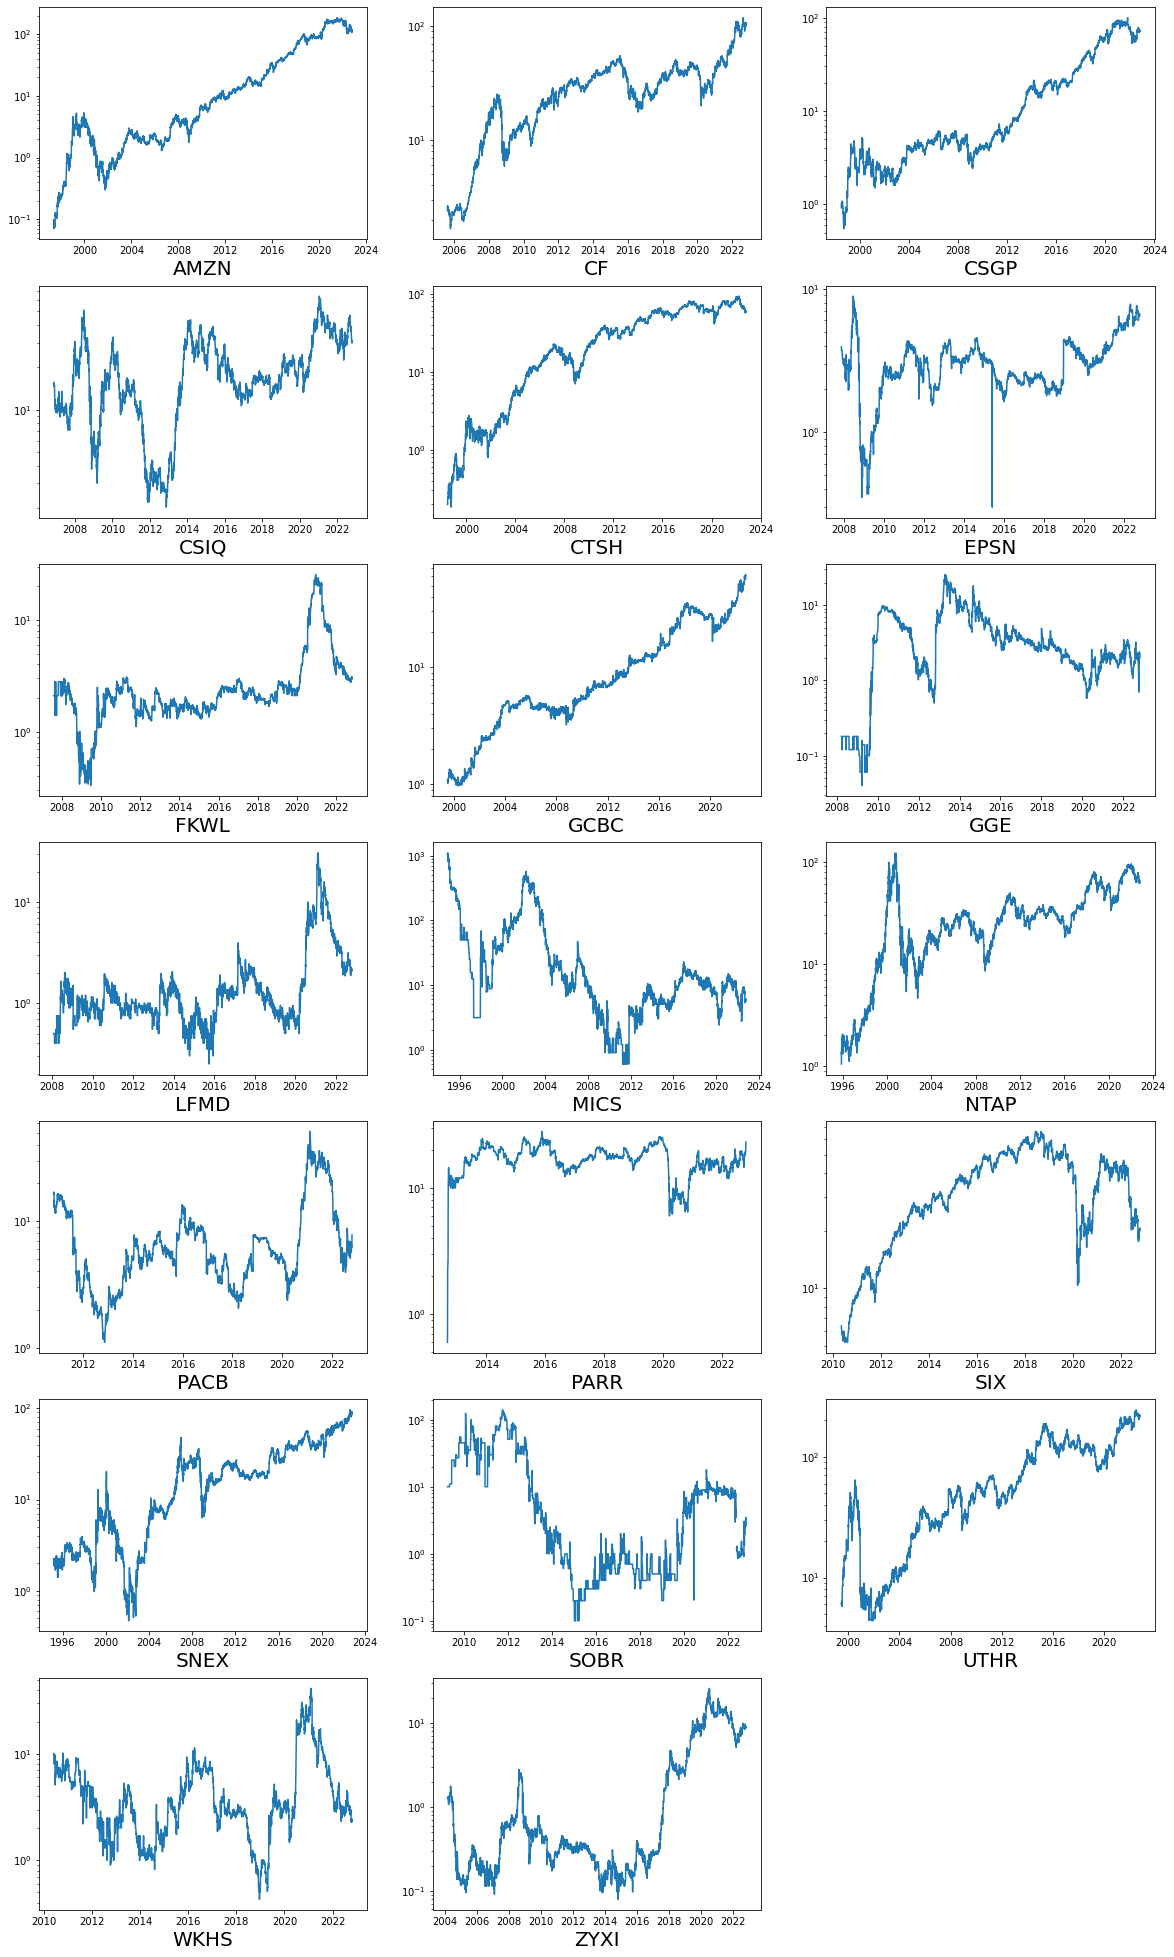

In [60]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

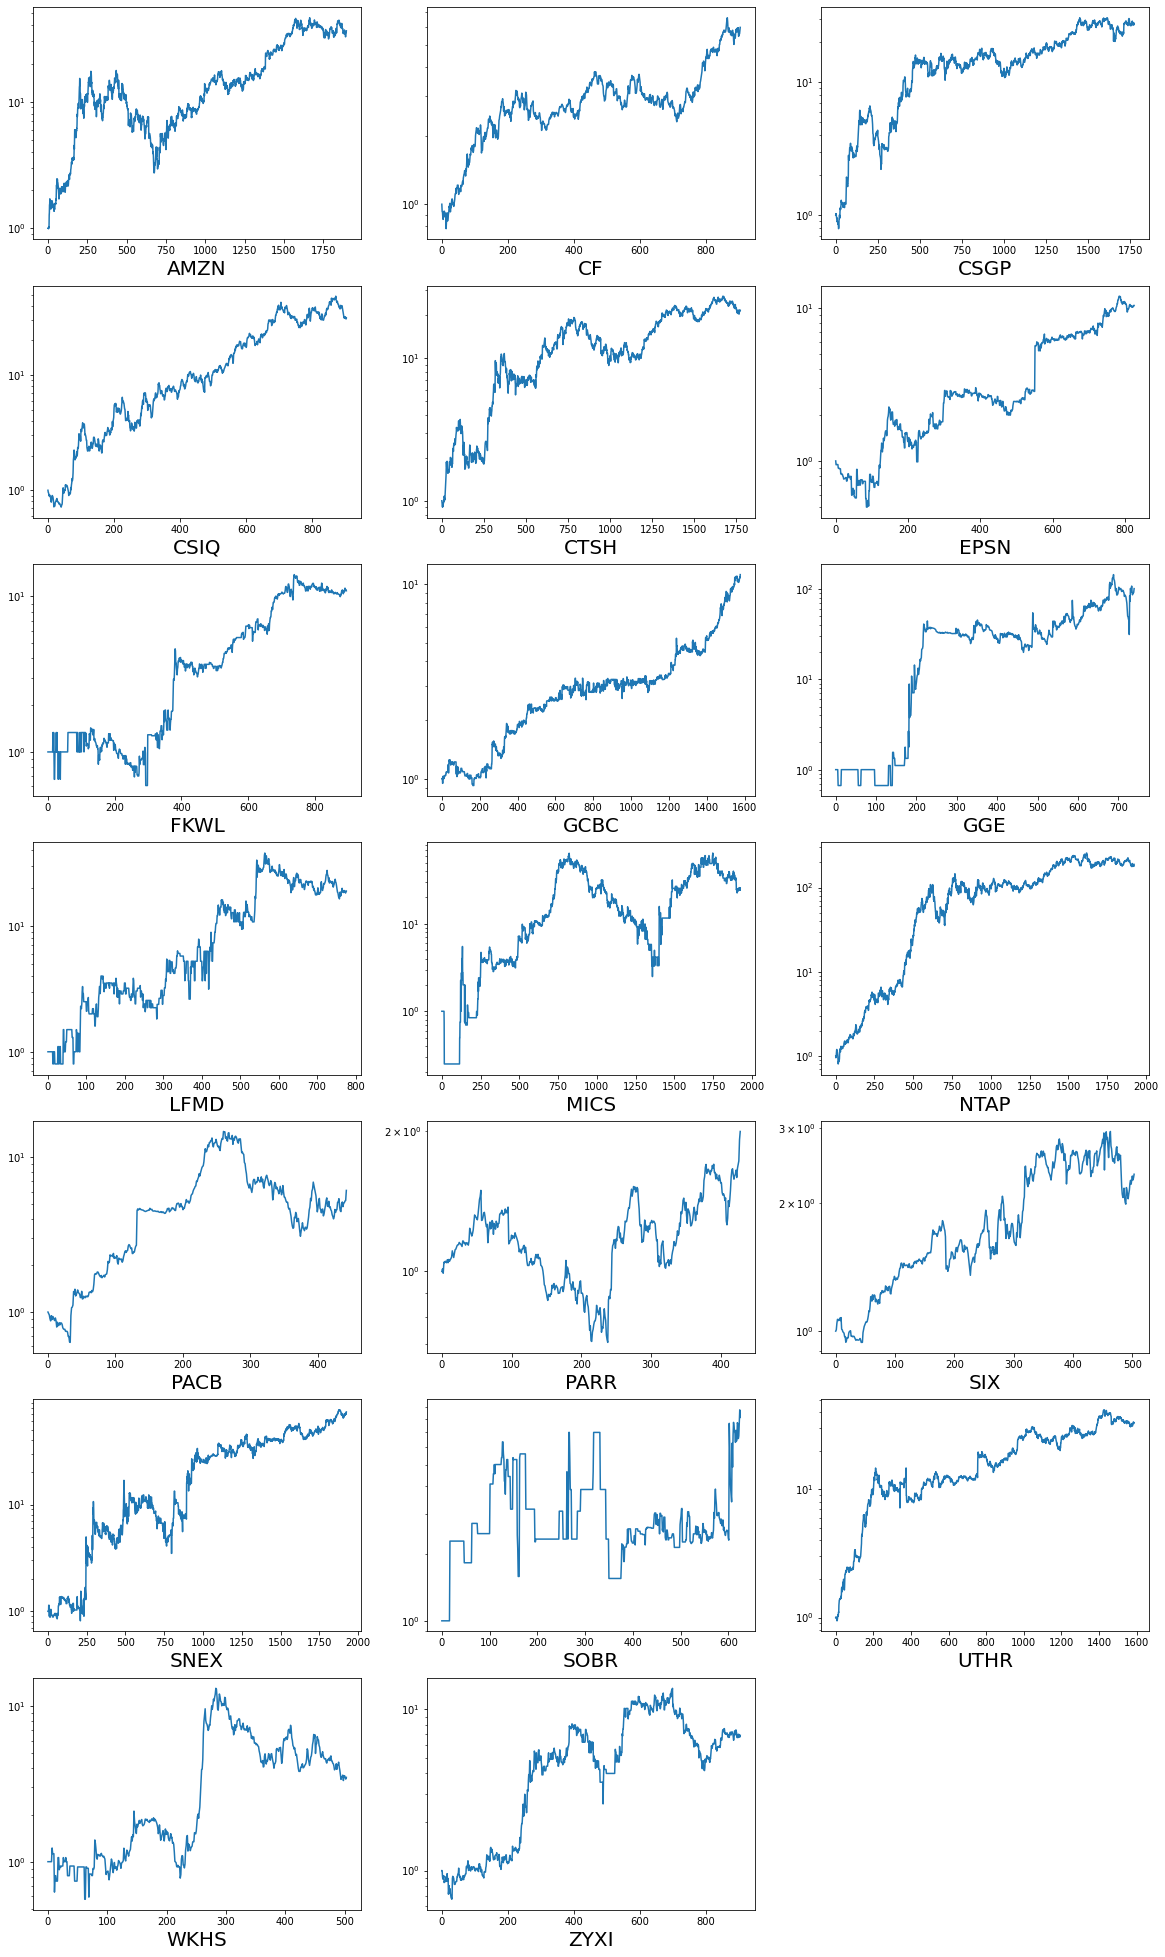

In [61]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [52]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()